##### Copyright 2018 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## PR-AUC Maximization
In this colab, we'll show how to use the TF Constrained Optimization (TFCO) library to train a model to maximize the *Area Under the Precision-Recall Curve (PR-AUC)*. We'll show how to train the model both with (i) plain TensorFlow (in eager mode), and (ii) with a custom tf.Estimator.

We start by importing the relevant modules.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn import metrics
from sklearn import model_selection
import tensorflow.compat.v2 as tf

In [0]:
# Tensorflow constrained optimization library
!pip install git+https://github.com/google-research/tensorflow_constrained_optimization
import tensorflow_constrained_optimization as tfco

## Communities and Crimes

We will use the  *Communities and Crimes* dataset from the UCI Machine Learning repository for our illustration. This dataset contains various demographic and racial distribution details (aggregated from census and law enforcement data sources) about different communities in the US, along with the per capita crime rate in each commmunity. 


We begin by downloading and preprocessing the dataset.

In [0]:
# List of column names in the dataset.
column_names = ["state", "county", "community", "communityname", "fold", "population", "householdsize", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par", "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"]

In [0]:
dataset_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

# Read dataset from the UCI web repository and assign column names.
data_df = pd.read_csv(dataset_url, sep=",", names=column_names,
                      na_values="?")
data_df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


The 'ViolentCrimesPerPop' column contains the per capita crime rate for each community. We label the communities with a crime rate above the 70-th percentile as 'high crime' and the others as 'low crime'. These would serve as our binary target labels.

In [0]:
# Make sure there are no missing values in the "ViolentCrimesPerPop" column.
assert(not data_df["ViolentCrimesPerPop"].isna().any())

# Binarize the "ViolentCrimesPerPop" column and obtain labels.
crime_rate_70_percentile = data_df["ViolentCrimesPerPop"].quantile(q=0.7)
labels_df = (data_df["ViolentCrimesPerPop"] >= crime_rate_70_percentile)

# Now that we have assigned binary labels, 
# we drop the "ViolentCrimesPerPop" column from the data frame.
data_df.drop(columns="ViolentCrimesPerPop", inplace=True)

We drop all categorical columns, and use only the numerical/boolean features.

In [0]:
data_df.drop(columns=["state", "county", "community", "communityname", "fold"],
             inplace=True)

Some of the numerical columns contain missing values (denoted by a NaN). For each feature that has at least one value missing, we append an additional boolean "is_missing" feature indicating that the value was missing, and fill the missing value with 0.

In [0]:
feature_names = data_df.columns
for feature_name in feature_names:  
    # Which rows have missing values?
    missing_rows = data_df[feature_name].isna()
    if missing_rows.any():  # Check if at least one row has a missing value.
        data_df[feature_name].fillna(0.0, inplace=True)  # Fill NaN with 0.
        missing_rows.rename(feature_name + "_is_missing", inplace=True)
        data_df = data_df.join(missing_rows)  # Append "is_missing" feature.

Finally, we divide the dataset randomly into two-thirds for training and one-thirds for testing.

In [0]:
# Set random seed so that the results are reproducible.
np.random.seed(123456)

# Train and test indices.
train_indices, test_indices = model_selection.train_test_split(
    np.arange(data_df.shape[0]), test_size=1./3.)

# Train and test data.
x_train_df = data_df.loc[train_indices].astype(np.float32)
y_train_df = labels_df.loc[train_indices].astype(np.float32)
x_test_df = data_df.loc[test_indices].astype(np.float32)
y_test_df = labels_df.loc[test_indices].astype(np.float32)

# Convert data frames to NumPy arrays.
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values

## (i) PR-AUC Training with Plain TF

In [0]:
batch_size = 128  # first fix the batch size for mini-batch training


We will work with a linear classification model and define the data and model tensors. 


In [0]:
# Create linear Keras model.
layers = []
layers.append(tf.keras.Input(shape=(x_train.shape[-1],)))
layers.append(tf.keras.layers.Dense(1))
model = tf.keras.Sequential(layers)

# Create nullary functions that return labels and logits from the current
# batch. In eager mode, TFCO requires these to be provided via nullary function.
# We will maintain a running array of batch indices.
batch_indices = np.arange(batch_size)
labels_fn = lambda: tf.constant(y_train[batch_indices], dtype=tf.float32)
logits_fn = lambda: model(x_train[batch_indices, :])

We next set up the constraint optimization problem to optimize PR-AUC.


In [0]:
# Create context with labels and predictions.
context = tfco.rate_context(logits_fn, labels_fn)

# Create optimization problem with PR-AUC as the objective. The library
# expects a minimization objective, so we negate the PR-AUC. 

# We use the pr_auc rate helper which uses a Riemann approximation to the area 
# under the precision-recall curve (recall on the horizontal axis, precision on 
# the vertical axis). We would need to specify the the number of bins 
# ("rectangles") to use for the Riemann approximation. We also can optionally
# specify the surrogate to be used to approximate the PR-AUC.
pr_auc_rate = tfco.pr_auc(
    context, bins=10, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
problem = tfco.RateMinimizationProblem(-pr_auc_rate)

We then create a loss function from the `problem` and optimize it to train the model.

In [0]:
# Create Lagrangian loss for `problem`. What we get back is a loss function, a 
# a nullary function that returns a list of update_ops that need to be run 
# before every gradient update, and the Lagrange multiplier variables internally
# maintained by the loss function. The argument `dual_scale` is a 
# hyper-parameter that specifies the relative importance placed on updates on 
# the Lagrange multipliers.
loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
    problem, dual_scale=1.0)

# Set up optimizer and the list of variables to optimize.
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
var_list = (model.trainable_weights + problem.trainable_variables + 
            [multipliers])

Before proceeding to solving the training problem, we write an evaluation function.

In [0]:
def pr_auc(model, features, labels):
    # Returns the PR-AUC for given model, features and binary labels.
    scores = model.predict(features)
    return metrics.average_precision_score(labels, scores)

We are now ready to train our model. 

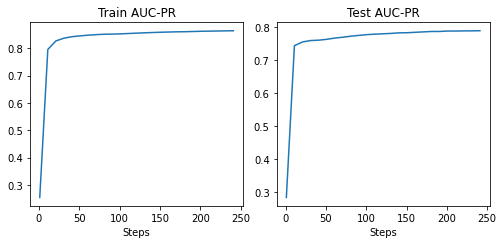

In [0]:
num_steps = 250
num_examples = x_train.shape[0]

train_objectives = []
test_objectives = []

for ii in range(num_steps):
  # Indices for current batch; cycle back once we reach the end of stream.
  batch_indices = np.arange(ii * batch_size, (ii + 1) * batch_size)
  batch_indices = [ind % num_examples for ind in batch_indices]

  # First run update ops, and then gradient update.
  update_ops_fn()
  optimizer.minimize(loss_fn, var_list=var_list)

  # Record train and test objectives once every 10 steps.
  if ii % 10 == 0:
    train_objectives.append(pr_auc(model, x_train, y_train))
    test_objectives.append(pr_auc(model, x_test, y_test))

# Plot training and test objective as a function of steps.
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ax[0].plot(np.arange(1, num_steps + 1, 10), train_objectives)
ax[0].set_title('Train PR-AUC')
ax[0].set_xlabel('Steps')
ax[1].plot(np.arange(1, num_steps + 1, 10), test_objectives)
ax[1].set_title('Test PR-AUC')
ax[1].set_xlabel('Steps')
fig.tight_layout()

# (ii) PR-AUC Training with Custom Estimators

We next show how one can use TFCO to optimize PR-AUC using custom tf.Estimators.

We first create `feature_columns` to convert the dataset into a format that can be processed by an estimator.

In [0]:
feature_columns = []
for feature_name in x_train_df.columns:
  feature_columns.append(
      tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

We next construct the input functions that return the data to be used by the estimator for training/evaluation.

In [0]:
def make_input_fn(
    data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_fn():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_fn

train_input_fn = make_input_fn(x_train_df, y_train_df, num_epochs=25)
test_input_fn = make_input_fn(x_test_df, y_test_df, num_epochs=1, shuffle=False)

We then write the model function that is used by the estimator to create the model, loss, optimizers and metrics.

In [0]:
def make_model_fn(feature_columns):
  # Returns model_fn.

  def model_fn(features, labels, mode):
    # Create model from features.
    layers = []
    layers.append(tf.keras.layers.DenseFeatures(feature_columns))
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    logits = model(features)

    # Baseline cross-entropy loss.
    baseline_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    baseline_loss = baseline_loss_fn(labels, logits)

    # As a slight variant from the above previous training, we will optimize a 
    # weighted combination of PR-AUC and the baseline loss.
    baseline_coef = 0.2
    
    train_op = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      # Set up PR-AUC optimization problem.
      # Create context with labels and predictions.
      context = tfco.rate_context(logits, labels)

      # Create optimization problem with PR-AUC as the objective. The library
      # expects a minimization objective, so we negate the PR-AUC. We optimize
      # a convex combination of (negative) PR-AUC and the baseline loss (wrapped
      # in a rate object).
      pr_auc_rate = tfco.pr_auc(
          context, bins=10, penalty_loss=tfco.SoftmaxCrossEntropyLoss())
      problem = tfco.RateMinimizationProblem(
          (1 - baseline_coef) * (-pr_auc_rate) + 
          baseline_coef * tfco.wrap_rate(baseline_loss))

      # Create Lagrangian loss for `problem`. What we get back is a loss 
      # function, a nullary function that returns a list of update_ops that 
      # need to be run before every gradient update, and the Lagrange 
      # multipliers maintained internally by the loss.
      # The argument `dual_scale` is a hyper-parameter that specifies the  
      # relative importance placed on updates on the Lagrange multipliers.
      loss_fn, update_ops_fn, multipliers = tfco.create_lagrangian_loss(
          problem, dual_scale=1.0)
      
      # Set up optimizer and the list of variables to optimize the loss.
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
      optimizer.iterations = tf.compat.v1.train.get_or_create_global_step()
      
      # Get minimize op and group with update_ops.
      var_list = (
          model.trainable_weights + problem.trainable_variables + [multipliers])
      minimize_op = optimizer.get_updates(loss_fn(), var_list)
      update_ops = update_ops_fn()
      train_op = tf.group(*update_ops, minimize_op)

    # Evaluate PR-AUC.
    pr_auc_metric = tf.keras.metrics.AUC(curve='PR')
    pr_auc_metric.update_state(labels, tf.sigmoid(logits))

    # We do not use the Lagrangian loss for evaluation/bookkeeping
    # purposes as it depends on some internal variables that may not be
    # set properly during evaluation time. We instead pass loss=baseline_loss.
    return tf.estimator.EstimatorSpec(
        mode=mode, 
        predictions=logits, 
        loss=baseline_loss,
        train_op=train_op,
        eval_metric_ops={'PR-AUC': pr_auc_metric})
    
  return model_fn

We are now ready to train the estimator.

In [0]:
# Create a temporary model directory.
model_dir = "tfco_tmp"
if os.path.exists(model_dir):
  shutil.rmtree(model_dir)

# Train estimator.
estimator_lin = tf.estimator.Estimator(
    make_model_fn(feature_columns), model_dir=model_dir)
estimator_lin.train(train_input_fn, steps=250) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp/tfco_206861', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variab

Finally, we evaluate the trained model on the test set.

In [0]:
estimator_lin.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-07T19:15:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/tfco_206861/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.57194s
INFO:tensorflow:Finished evaluation at 2020-04-07-19:15:45
INFO:tensorflow:Saving dict for global step 250: AUCPR = 0.7830894, global_step = 250, loss = 0.38406006
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250: tmp/tfco_206861/model.ckpt-250


{'AUCPR': 0.7830894, 'global_step': 250, 'loss': 0.38406006}

## Closing Remarks

Before closing, we point out that there are three main hyper-paramters you may want to tune to improve the PR-AUC training:

- `learning_rate`
- `dual_scale`
- `baseline_coeff`

You may also be interested in exploring helpers for other similar metrics that TFCO allows you to optimize:
- `tfco.precision_at_recall`
- `tfco.recall_at_precision`
- `tfco.inverse_precision_at_recall`